In [1]:
# Import pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from pygeocoder import Geocoder
from geopy.geocoders import Nominatim
from geopy.distance import vincenty



In [2]:
# Pull the comprehensive police reported incidents file, dated from 2007 to 2013.
incidents_180 = pd.read_csv('arrests_180_days.csv')
incidents_180.dropna(inplace=True)
incidents_180.head(13)

,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
0,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),2/13/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
1,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),1/2/17 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
2,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),12/9/16 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
3,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),12/14/16 17:00,0 BLOCK UNKNOWN,92020.0,EL CAJON
4,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),3/28/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
5,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),1/25/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
6,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),2/13/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
7,OCEANSIDE,290 VIOLATION AFTER INCARCERATION (M),3/17/17 10:30,CROUCH STREET / SKYLARK DRIVE,92054.0,OCEANSIDE
8,SHERIFF,290 VIOLATION AFTER INCARCERATION (M),12/19/16 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
9,SHERIFF,290 VIOLATION TRAN 30 DAY UPDATE (F),5/5/17 16:30,9100 BLOCK MISSION GORGE ROAD,92071.0,SANTEE


In [3]:
#we want info on just DUI incidents
dui_incidents_180 = incidents_180[incidents_180['Charge_Description_Orig'].str.contains("DUI")]
dui_incidents_180


,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
15932,EL CAJON,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,5/12/17 1:39,700 S BLOCK MAGNOLIA AVENUE,92020.0,EL CAJON
15933,CHULA VISTA,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,3/10/17 0:09,EVANS AVENUE / E L STREET,91911.0,CHULA VISTA
15935,SHERIFF,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,2/3/17 22:25,400 BLOCK ALMOND ROAD,92078.0,SAN MARCOS
18415,EL CAJON,DUI .08 ALC:CAUSING BODILY INJ (F),3/24/17 20:20,N 03RD STREET / E MAIN STREET,92020.0,EL CAJON
18416,OCEANSIDE,DUI .08 ALC:CAUSING BODILY INJ (F),12/22/16 21:28,4000 BLOCK VISTA WAY,92056.0,OCEANSIDE
18417,SHERIFF,DUI .08 ALC:CAUSING BODILY INJ (F),1/7/17 12:40,2700 S BLOCK 101,92007.0,ENCINITAS
18418,ESCONDIDO,DUI .08 ALC:CAUSING BODILY INJ (F),5/7/17 17:30,N ESCONDIDO BOULEVARD / W WASHINGTON AVENUE,92025.0,ESCONDIDO
18419,ESCONDIDO,DUI .08 ALC:CAUSING BODILY INJ (F),4/28/17 18:20,2100 BLOCK CITRACADO PARKWAY,92029.0,ESCONDIDO
18420,ESCONDIDO,DUI .08 ALC:CAUSING BODILY INJ (F),3/24/17 20:05,S CENTRE CITY PARKWAY / W FELICITA AVENUE,92025.0,ESCONDIDO
18422,ESCONDIDO,DUI .08 ALC:CAUSING BODILY INJ (F),3/25/17 20:22,E VALLEY PY LAKE WOHLFORD ROAD,92027.0,ESCONDIDO


In [4]:

zip_code_df = pd.read_csv('ZipCode_Populations.csv')
zip_code_df.head(18)

,Zip,YEAR,RACE,NUMBER
0,91901,2010,Pacific Islander,43
1,91901,2010,White,13131
2,91901,2010,Black,201
3,91901,2010,Other,9
4,91901,2010,Two or More,375
5,91901,2010,American Indian,326
6,91901,2010,Hispanic,2663
7,91901,2010,Asian,336
8,91902,2010,Asian,1775
9,91902,2010,Hispanic,7146


In [5]:
# Population
# Draw a circle around a zip code point
#zip_pop = zip_code[pop]/r^2

In [6]:
curr_zip = zip_code_df['Zip'][0]

sums = {}
temp_sum = 0

for i in range(0,len(zip_code_df)):    
    if curr_zip != zip_code_df.iloc[i]['Zip']:
        sums[curr_zip] = temp_sum
        curr_zip = zip_code_df.iloc[i]['Zip']
        temp_sum = zip_code_df.iloc[i]['NUMBER']
    else:
        temp_sum += zip_code_df.iloc[i]['NUMBER']

In [7]:
print(sums)

{91901: 17084, 91902: 17005, 91905: 1669, 91906: 5765, 91910: 76153, 91911: 83249, 91913: 40346, 91914: 15627, 91915: 25126, 91916: 2006, 91917: 2276, 91931: 350, 91932: 26325, 91934: 775, 91935: 8235, 91941: 33302, 91942: 36886, 91945: 25320, 91948: 340, 91950: 55312, 91962: 1698, 91963: 1162, 91977: 59164, 91978: 7956, 91980: 173, 92003: 4354, 92004: 4054, 92007: 10531, 92008: 27568, 92009: 39735, 92010: 14481, 92011: 22393, 92014: 13432, 92019: 42637, 92020: 58407, 92021: 65227, 92024: 52579, 92025: 48275, 92026: 52417, 92027: 53143, 92028: 46449, 92029: 18624, 92036: 3573, 92037: 38652, 92040: 40286, 92054: 37941, 92055: 33412, 92056: 51590, 92057: 54152, 92058: 23406, 92059: 1498, 92060: 778, 92061: 2855, 92064: 47904, 92065: 35365, 92066: 430, 92067: 8689, 92069: 46322, 92070: 697, 92071: 53211, 92075: 11854, 92078: 39983, 92081: 27422, 92082: 17896, 92083: 37082, 92084: 47861, 92086: 1131, 92091: 1621, 92093: 8718, 92096: 622, 92101: 35623, 92102: 42967, 92103: 30680, 92104: 449

In [8]:
df_zip_coords = pd.read_csv('Zip_Coords.csv')
# Drop unnecessary columns from data, such as Status, City, and State, since we already 
# know our zip code values are San Diego specific.
df_zip_coords.drop(['Idk', 'City', 'State', 'Status'], axis=1, inplace=True)
df_zip_coords.head(10)
for i in range(0, len(df_zip_coords)):
    df_zip_coords.iloc[i]['Zip Code'] = str(df_zip_coords.iloc[i]['Zip Code'])
#print("Length: ", len(df_zip_coords))
df_zip_coords.head(10)


/Users/sarahgeorge/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Zip Code,Lat,Lon
0,92101,32.71,-117.16
1,92102,32.72,-117.09
2,92103,32.74,-117.17
3,92104,32.73,-117.12
4,92105,32.73,-117.08
5,92106,32.72,-117.23
6,92107,32.73,-117.24
7,92107,32.73,-117.24
8,92108,32.77,-117.10
9,92109,32.79,-117.23


In [9]:
for i in sums:
    sums[i] = str(sums[i])
df_zip_pops = pd.DataFrame.from_dict(sums, orient='index').reset_index()
df_zip_pops.rename(columns = {'index':'Zip Code', 0:'Population'}, inplace=True)

In [10]:
# Look at data
print("Length: ", len(df_zip_pops))
df_zip_pops.head(10)


Length:  110


,Zip Code,Population
0,91901,17084
1,91902,17005
2,91905,1669
3,91906,5765
4,91910,76153
5,91911,83249
6,91913,40346
7,91914,15627
8,91915,25126
9,91916,2006


In [57]:
# Merge our first dataset with zipcode coordinates with our second dataset with zipcode
# populations.
merged_zips = pd.merge(df_zip_coords, df_zip_pops, on='Zip Code')
merged_zips = merged_zips.drop_duplicates()
print("Length: ", len(merged_zips))

merged_zips = merged_zips.reset_index(drop=True)

Length:  39


In [58]:
# Population:
# Draw a circle around a zip code point
# zip_pop = zip_code[pop]/r^2
# *Note* this is assuming evenly distributed population in a zip code area

distributed_pop = pd.Series()
merged_zips['distributed_pop'] = distributed_pop
merged_zips.head(5)
radius = 2
#print((int(merged_zips.iloc[0]['Population']))/(radius*radius))
#(int(merged_zips.iloc[0]['Population']))/(radius^2)
for i in range(0, len(merged_zips)):
    merged_zips.set_value(i, 'distributed_pop', str(((int(merged_zips.iloc[i]['Population']))/(radius*radius))))

merged_zips = merged_zips[['Lat','Lon','distributed_pop']]
merged_zips

,Lat,Lon,distributed_pop
0,32.71,-117.16,8905.75
1,32.72,-117.09,10741.75
2,32.74,-117.17,7670.00
3,32.73,-117.12,11236.75
4,32.73,-117.08,17567.50
5,32.72,-117.23,5461.75
6,32.73,-117.24,6732.25
7,32.77,-117.10,4547.75
8,32.79,-117.23,11450.50
9,32.77,-117.18,5963.00


# Now lets put all of our data into a matrix of lists
We are going to make a matrix based off of coordinates ranges in our map. Each square in the map with contains a list of 4 items: 

crashes -  number of DUI related crashes in the area

arrests - number of DUI related arrests in the area

licenses - number of alcohol licenses in the area

population - population size in the area

In [71]:
# Grid things

min_lat = 32.54
max_lat = 33.05
min_lon = -117.25
max_lon = -116.95

#number of matrix columns and rows
matrix_dim = 10

#make matrix
matrix = [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]

#width of a cell
cell_width = abs((max_lat - min_lat)/matrix_dim)

#height of a cell
cell_height = (max_lon - min_lon)/matrix_dim

print("Matrix will be of dimension " + str(matrix_dim) + "x" + str(matrix_dim) + '\n')
print("Cell width: " + str(cell_width) + " latitude points")
print("Cell height: " + str(cell_height) + " longitude points" + '\n')

print(matrix)

Matrix will be of dimension 10x10

Cell width: 0.0509999999999998 latitude points
Cell height: 0.029999999999999714 longitude points

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [72]:
# Crash array
crash_data = pd.read_csv('crash_coordinates.csv')
crash_data.head(5)

# merged_zips has lat/lon data

,0,"(30.0206764, -90.10265509999999)"
0,1,"(32.9178621, -117.1426708)"
1,2,"(41.4580185, -96.4925694)"
2,3,"(38.9062481, -90.13781209999999)"
3,4,"(36.077923, -102.519732)"
4,5,"(32.6972057, -117.032704)"


In [73]:
# Arrest array
arrest_data = pd.read_csv('dui_incidents_180.csv')
arrest_data = arrest_data['coordinates']

arrest_coords_arr = np.zeros(len(arrest_data), dtype=('2float'))
coord = []
# Organize arrest coordinates 
for i in range(0,len(arrest_data)-1):
    coord = arrest_data.iloc[i]
    opening_paren_index = coord.find("(")
    comma_index = coord.find(",")
    closing_parn_index = coord.find(")")
    arrest_lat = float(coord[opening_paren_index+1:comma_index])
    arrest_lng = float(coord[comma_index+2:closing_parn_index])
    arrest_coords_arr[i] = ((arrest_lat,arrest_lng))

In [74]:
# Crash array
crash_coords_df = pd.read_csv('crash_coordinates.csv')

crash_coords_arr = np.zeros(len(df_zip_coords), dtype=('2float'))
for i in range(0,len(crash_coords_arr)-1):
    coord = crash_coords_df.iloc[i]
    opening_paren_index = coord[1].find("(")
    comma_index = coord[1].find(",")
    closing_parn_index = coord[1].find(")")
    crash_lat = float(coord[1][opening_paren_index+1:comma_index])
    crash_lng = float(coord[1][comma_index+2:closing_parn_index])
    crash_coords_arr[i] = ((crash_lat,crash_lng))



In [75]:
# Alcohol permit array

alc_permits = pd.read_csv('abs-licenses-casnd.csv')
crash_coordinates_s = pd.read_csv("crash_coordinates.csv")
#alc_permits.head(5)
crash_coordinates_s.head(5)
# Reduce to pertinent data columns
alc_permits = alc_permits[['last_date', 'status', 'issuedate', 'exprdate', 'lon', 'lat', 'business']]
# Filter out data that may be outside the San Diego area.
# Limit range so that any outliers or typos in data are eliminated

alc_permits = alc_permits.drop(alc_permits[alc_permits['lon'] < -120].index)
alc_permits.dropna(inplace = True)
#Alcohol Permits SCATTER PLOTTING

permit_coords = np.zeros(len(alc_permits), dtype=('2float'))

for i in range(0, len(alc_permits)):
    alc_lat = float(alc_permits['lat'].iloc[i])
    alc_lng = float(alc_permits['lon'].iloc[i])
    permit_coords[i] = (alc_lat, alc_lng)



In [90]:
# Input data into matrix lists

for i in range(matrix_dim):
    for j in range(matrix_dim):
        # Initialize array to count instances that a coordinate meets boundary conditions
        in_list=[]
        crash_array=[]
        arrest_array=[]
        permit_array=[]
        pop_array=[]
        #print(float(merged_zips.loc[0][1]))
        for k in range(len(crash_coords_arr)):
            crash_bool = ((crash_coords_arr[k][0] >= min_lat + cell_width*i) 
                             and (crash_coords_arr[k][0] <= min_lat + cell_width*(i+1))
                             and (crash_coords_arr[k][1] >= min_lon + cell_height*j) 
                             and (crash_coords_arr[k][1] <= min_lon + cell_height*(j+1)))
            if crash_bool == True:
                crash_array.append(1)
        for k in range(len(arrest_coords_arr)):
            arrest_bool = ((arrest_coords_arr[k][0] >= min_lat + cell_width*i) 
                             and (arrest_coords_arr[k][0] <= min_lat + cell_width*(i+1))
                             and (arrest_coords_arr[k][1] >= min_lon + cell_height*j) 
                             and (arrest_coords_arr[k][1] <= min_lon + cell_height*(j+1)))
            if arrest_bool == True:
                arrest_array.append(1)
        for k in range(len(permit_coords)):
            permit_bool = ((permit_coords[k][0] >= min_lat + cell_width*i) 
                             and (permit_coords[k][0] <= min_lat + cell_width*(i+1))
                             and (permit_coords[k][1] >= min_lon + cell_height*j) 
                             and (permit_coords[k][1] <= min_lon + cell_height*(j+1)))
            if permit_bool == True:
                permit_array.append(1)
        for k in range(len(merged_zips)):
            pop_bool = ((float(merged_zips.loc[k][0]) >= min_lat + cell_width*i) 
                             and (float(merged_zips.loc[k][0]) <= min_lat + cell_width*(i+1))
                             and (float(merged_zips.loc[k][1]) >= min_lon + cell_height*j) 
                             and (float(merged_zips.loc[k][1]) <= min_lon + cell_height*(j+1)))
            if pop_bool == True:
                pop_array.append(merged_zips.loc[k][2])
        ###############################
        # list[0] = # of crashes
        # list[1] = # of arrests
        # list[2] = # of permits
        # list[3] = # of people
        ###########################
        in_list.append(len(crash_array))
        in_list.append(len(arrest_array))
        in_list.append(len(permit_array))
        in_list.append(sum(pop_array))
        matrix[j][i] = in_list
print(matrix)

### NOTE: Sum for population count

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 4, 85, 12194.0], [6, 38, 58, 11450.5], [1, 24, 60, 0], [0, 2, 11, 0], [1, 3, 23, 0], [0, 0, 120, 0], [0, 0, 8, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 46, 858.75], [2, 10, 139, 0], [3, 32, 36, 12654.25], [2, 8, 56, 10845.5], [0, 0, 16, 1063.25], [0, 1, 4, 12429.0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 41, 283.75], [0, 1, 183, 19064.5], [5, 5, 86, 5963.0], [0, 13, 55, 24621.75], [0, 0, 13, 0], [0, 0, 16, 0], [1, 1, 2, 12429.0], [0, 0, 0, 0]], [[0, 0, 8, 0], [0, 0, 1, 0], [0, 0, 0, 4544.0], [1, 8, 153, 8944.5], [6, 17, 152, 0], [1, 12, 130, 18553.25], [0, 0, 11, 18259.75], [3, 3, 21, 0], [0, 1, 2, 0], [0, 1, 0, 0]], [[0, 0, 12, 0], [0, 0, 5, 0], [0, 2, 23, 15689.75], [0, 3, 72, 11236.75], [1, 21, 129, 12407.5], [0, 2, 30, 6585.75], [0, 0, 11, 18259.25], [1, 4, 36, 0], [0, 4, 19, 12802.0], [0, 0, 18, 9818.0]], [[0, 0, 13, 0], [0, 0, 82, 0], [0, 0, 112, 0], [5, 6, 29, 28309.25], [3, 18, 89, 4547.75], [1, 2, 8, 758

# Let's get some good graphs!!! (Data Visualisation)

In [ ]:
# ScatterPlot #1: Crashes v. Arrests, Linear Regression
# OLS: How well does each variable predict the other?

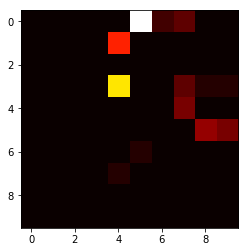

In [112]:
# HEATMAPPING ARRESTS
arrest_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        arrest_matrix[i][j] = in_list[1]/population

plt.imshow(arrest_matrix, cmap='hot', interpolation='nearest')
plt.show()

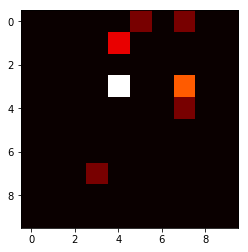

In [113]:
# HEATMAPPING Crashes
crash_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        crash_matrix[i][j] = in_list[0]/population

plt.imshow(crash_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
# TO DO:
# Another heatmap with ratio of arrest and crash numbers
# Add scales to label the heatmaps


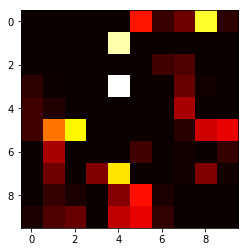

In [114]:
# HEATMAPPING Permits
permit_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        permit_matrix[i][j] = in_list[2]/population

plt.imshow(permit_matrix, cmap='hot', interpolation='nearest')
plt.show()

Ratio of Crashes vs. Arrests:  0.130850866568


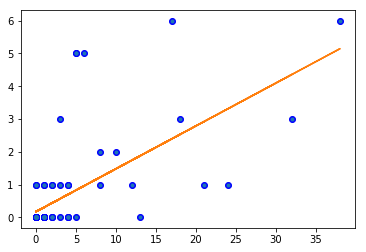

In [134]:
# ARREST v. CRASH SCATTERPLOT
import matplotlib.patches as mpatches
#fig = plt.figure()
#ax1 = fig.add_subplot(111)

arrest_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        arrest_matrix_scatter[i][j] = in_list[1]

crash_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        crash_matrix_scatter[i][j] = in_list[0]


A1 = np.array(arrest_matrix_scatter).flatten()
A2 = np.array(crash_matrix_scatter).flatten()

plt.scatter(A1[:],A2[:], c='blue')
# sample data
x = A1
y = A2
#print(x)
# fit with np.polyfit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
print("Ratio of Crashes vs. Arrests: ", m)

plt.show()

In [146]:
#OLS Modelling:

import patsy
import statsmodels.api as sm

# Take the arrays uses for crash and arrest data, and create an OLS model.
arrest_crashes = pd.DataFrame({'x': x, 'y':y})
outcome, predictors = patsy.dmatrices('x ~ y', )

mod = sm.OLS(outcome,predictors)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     72.73
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           1.87e-13
Time:                        15:31:07   Log-Likelihood:                -300.46
No. Observations:                 100   AIC:                             604.9
Df Residuals:                      98   BIC:                             610.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.9846      0.533      1.847      0.0

In [148]:
# One more test: Sort matrix cells by population, 
# create a histogram that shows what the distribution
# of arrests/crashes is. Could be an exponential distribution?

## Also to do:
# Add more OLS tests between all poss. variable combinations

# Discussion

# Conclusion